# Cancer Prediction with PySpark using Random Forest

In this project, we'll walk through using PySpark to solve a classification problem. Specifically, we'll develop a random forest model to predict if a tumor is benign or malignant based on numerous numerical observations. 

This project will be utilizing Spark's ML library, which is designed to be used with DataFrame structures and utilizes pipelines to make things efficient and concise. 

Let's import some stuff first

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql.types import DoubleType
from pyspark.sql.types import LongType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import sum
from pyspark.sql.functions import array
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, PipelineModel

import matplotlib.pyplot as plt
%matplotlib inline

#the following lines allow the notebook to have multiple outputs for a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

This particular dataset consists of 10 distinct measurements, such as radius of tumor, texture of tumor, etc. For each feature, there is a mean, standard error, and "worst" or largest value. To keep things simple, I've just grabbed the mean values of each measurement.  

For more details on the dataset, visit this link:  
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data  

Note that I'm using PySpark with the databricks package to load csv data directly to a DataFrame. You should load the notebook with the following command:  
PYSPARK_DRIVER_PYTHON=ipython PYSPARK_DRIVER_PYTHON_OPTS="notebook" $SPARK_HOME/bin/pyspark --packages com.databricks:spark-csv_2.10:1.3.0  

We'll also split the data into test/train and validation sets.

In [2]:
#load data as dataframe
data = sqlContext.read.load('cancer.csv', format='com.databricks.spark.csv', header='true', inferSchema='true')

#keep only the features with average values. don't keep id either
data = data.select(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
                    'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 
                    'fractal_dimension_mean'])

#display the structure
data.printSchema()

#randomly split the data into a test/train set and validation set (80%/20%)
splits = data.randomSplit([0.8, 0.2])
data_train = splits[0]
data_val = splits[1]

#take a look at some data
data.limit(5).toPandas()

root
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)



,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Now we have to deal with our label, diagnosis, which is a string. Use StringIndexer to convert string-based categorical features to a numeric form.

In [3]:
#convert diagnosis --> diagnosis_numeric. no one-hot encoding required because this can only have 
#two values (benign or malignant)
stringIndexerDiagnosis = StringIndexer(inputCol='diagnosis', outputCol='label')

Ok, the next step is to combine all our features together into a feature vector. Note that there is no need to scale features here (ie, standardization is not required) as this is a tree based model. Call this feature vector "features", as the default name for the features vector for the random forest classifier is "features".

In [4]:
all_feats = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 
             'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
assemblerAllFeatures = VectorAssembler(inputCols=all_feats, outputCol='features')

Let's put together everything we've done so far in a pipeline, and test the output on the training data.

In [5]:
#define the pipeline
pipeline = Pipeline(stages=[stringIndexerDiagnosis, assemblerAllFeatures])

#fit the pipeline on the training data. what it means to "fit" the pipeline is to basically go through each of the 
#stages of the piepline and figure out the appropriate parameters. for example, in the stringIndexerDiagnosis stage, 
#it assigns benign=0 and malignant=1 (or vice versa)
pipelineModel = pipeline.fit(data_train)

#actually transform the data now that the pipeline is fit. note that the resultant features vector may be sparse
output = pipelineModel.transform(data_train)

#take a look at the output
output.limit(3).toPandas()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,label,features
0,B,7.691,25.44,48.34,170.4,0.08668,0.11990,0.09252,0.01364,0.2037,0.07751,0.0,"[7.691, 25.44, 48.34, 170.4, 0.08668, 0.1199, ..."
1,B,7.729,25.49,47.98,178.8,0.08098,0.04878,0.00000,0.00000,0.1870,0.07285,0.0,"[7.729, 25.49, 47.98, 178.8, 0.08098, 0.04878,..."
2,B,7.760,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.0,"[7.76, 24.54, 47.92, 181.0, 0.05263, 0.04362, ..."


It's generally a good idea to take a look at the correlations between input features. This is a good first step at feature selection, in which we can remove any highly correlated (and therefore redundant) features. To do correlation analysis, select all the features and conver to a Pandas DataFrame.

correlation matrix:


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
radius_mean,1.000000,0.359657,0.997695,0.987078,0.155305,0.500692,0.681405,0.818004,0.167295,-0.296278
texture_mean,0.359657,1.000000,0.364246,0.355019,-0.022673,0.244715,0.318619,0.317305,0.060946,-0.071381
perimeter_mean,0.997695,0.364246,1.000000,0.986239,0.195223,0.553375,0.722670,0.848153,0.204963,-0.243678
area_mean,0.987078,0.355019,0.986239,1.000000,0.163579,0.493457,0.689762,0.817949,0.174611,-0.268104
smoothness_mean,0.155305,-0.022673,0.195223,0.163579,1.000000,0.676991,0.535203,0.557821,0.572308,0.613385
compactness_mean,0.500692,0.244715,0.553375,0.493457,0.676991,1.000000,0.889785,0.838213,0.634319,0.587738
concavity_mean,0.681405,0.318619,0.722670,0.689762,0.535203,0.889785,1.000000,0.930081,0.538885,0.356105
concave points_mean,0.818004,0.317305,0.848153,0.817949,0.557821,0.838213,0.930081,1.000000,0.488991,0.197223
symmetry_mean,0.167295,0.060946,0.204963,0.174611,0.572308,0.634319,0.538885,0.488991,1.000000,0.510457
fractal_dimension_mean,-0.296278,-0.071381,-0.243678,-0.268104,0.613385,0.587738,0.356105,0.197223,0.510457,1.000000


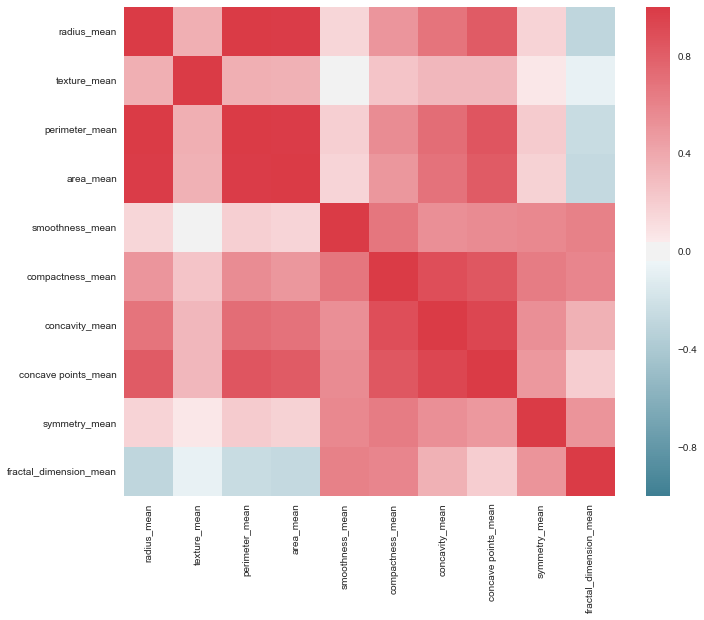

In [6]:
#note: if the data set is large, you should limit the number of samples before converting to pandas
cont_feats = data_train.select(all_feats).toPandas()

#compute the correlation matrix
corr = cont_feats.corr()
print 'correlation matrix:'
corr

#plot the correlation matrix as a heatmap 
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, ax=ax)
plt.show()

It turns out that there are many highly correlated features. Looking across all the columns in each row of the heat map, the biggest offenders based are radius_mean, perimeter_mean, area_mean, concave points_mean, and concavity_mean. These features are highly correlated with multiple other features.  

Let's update all_feats to exclude those features, and then take a look at the correlations again.

correlation matrix:


,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean
texture_mean,1.000000,-0.022673,0.244715,0.060946,-0.071381
smoothness_mean,-0.022673,1.000000,0.676991,0.572308,0.613385
compactness_mean,0.244715,0.676991,1.000000,0.634319,0.587738
symmetry_mean,0.060946,0.572308,0.634319,1.000000,0.510457
fractal_dimension_mean,-0.071381,0.613385,0.587738,0.510457,1.000000


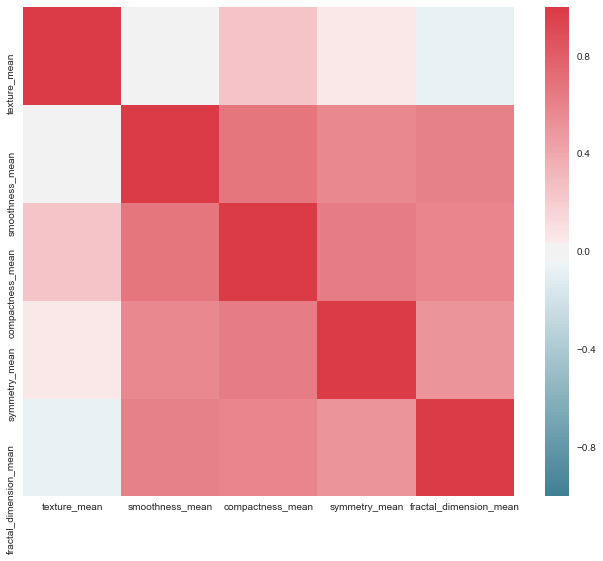

In [7]:
#exclude the highly correlated features
all_feats = ['texture_mean', 'smoothness_mean', 'compactness_mean',  'symmetry_mean', 'fractal_dimension_mean']
cont_feats = data_train.select(all_feats).toPandas()

#compute the correlation matrix
corr = cont_feats.corr()
print 'correlation matrix:'
corr

#plot the correlation matrix as a heatmap 
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, ax=ax)
plt.show()

That looks a lot better. There are still some correlated features, but much less so than originally.  

Now, let's put everything together. Define a new feature assembler that only assembles the non-correlated features. Define a random forest classifier with default parameters, and put everything together in a pipeline.

In [8]:
#define a new assembler on only the non-correlated features
assemblerAllFeatures = VectorAssembler(inputCols=all_feats, outputCol='features')

model = RandomForestClassifier()

#chain everything together into a pipeline
pipeline = Pipeline(stages=[stringIndexerDiagnosis, assemblerAllFeatures, model])

Note that we didn't define any of the parameters for the random forest classifier. As it turns out, there are two parameters that need to be optimized: the max depth of the trees, and the number of trees in the random forest. To identify the optimal values for these parameters, use the CrossValidator.  

I've set up the max depth to range from 1 to 10, and the number of trees to range from 5 to 70 in increments of 5. The metric used to determine the best performing model will be the area under the ROC, and the number of folds of cross validation are set to 3.

In [12]:
#define a ParamGridBuilder to determine optimal values of elasticNetParam (range [0,1]) and regParam (typically 
#ranges between 0 and 1). we'll sweep through 0 to 1 in increments of 0.1 for both parameters
paramGrid = ParamGridBuilder().addGrid(model.maxDepth, range(1,11)) \
                              .addGrid(model.numTrees, range(5,75,5)).build()

#define the RMSE to be the evaluation metric for model performance
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

#set up 3-fold cross validation to determine the optimal depth parameter (this can be set higher for potentially 
#better results)
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

#do the actual cross validation on the training data
CV_model = crossval.fit(data_train)

The CrossValidator iterated through every possible combination of maxDepth and numTrees, developed a model for each combination of values, and evaluated each model's performance based on the area under the ROC. The best performing model was saved and can now be accessed from the CV_model object. Let's take a closer look at it.

In [13]:
#get the best model
best_model = CV_model.bestModel

#for the best model, print out each tree in the random forest and list its depth and number of nodes
print ('number of trees: %i') % (len(best_model.stages[-1].trees))
best_model.stages[-1].trees

number of trees: 45


[DecisionTreeClassificationModel (uid=dtc_59ddb99f004d) of depth 7 with 69 nodes,
 DecisionTreeClassificationModel (uid=dtc_6057e4a41f15) of depth 7 with 77 nodes,
 DecisionTreeClassificationModel (uid=dtc_fa2d9296e5a6) of depth 7 with 73 nodes,
 DecisionTreeClassificationModel (uid=dtc_ae57c06defa3) of depth 7 with 63 nodes,
 DecisionTreeClassificationModel (uid=dtc_23dbea96d070) of depth 7 with 63 nodes,
 DecisionTreeClassificationModel (uid=dtc_c0d12ee7c54b) of depth 7 with 83 nodes,
 DecisionTreeClassificationModel (uid=dtc_d43191e48a61) of depth 7 with 75 nodes,
 DecisionTreeClassificationModel (uid=dtc_fb60dc3c7e57) of depth 7 with 67 nodes,
 DecisionTreeClassificationModel (uid=dtc_b4ac7f569fee) of depth 7 with 81 nodes,
 DecisionTreeClassificationModel (uid=dtc_bb12cd205749) of depth 7 with 67 nodes,
 DecisionTreeClassificationModel (uid=dtc_8eddaf6774eb) of depth 7 with 61 nodes,
 DecisionTreeClassificationModel (uid=dtc_25041af99c94) of depth 7 with 83 nodes,
 DecisionTreeCla

From the above output, we can see that the optimal max depth was identified to be 7 and the number of trees used was 45.  

Ok, so now let's evaluate our model. We can define a UDF that gives us our prediction based on the probability score of the random forest. The random forest model outputs a column of type vector which is [probability_class0, probability_class1]. So we can just define a probability threshold and output a new column containing the threshold-based prediction.  

We can also define some UDFs to calculate the true positives, true negatives, false positives, and false negatives. These will be used to calculate the precision, recall, and F1 score.

In [14]:
#define a UDF that will take the prediction probabilities, and return the predicted class according to some 
#defined threshold. vector is defined as [probability_class0, probability_class1] where class0 is benign and 
#class1 is malignant. let's set our probability threshold to a simple value of 0.5 for now.
prob_thresh = 0.5
prediction_udf = udf(lambda vector: float(0. if vector[0] > prob_thresh else 1.), FloatType())

#define UDF functions to calculate TP, TN, FP, FN
TP_udf = udf(lambda arr: int(1 if int(arr[0]) == 1 and int(arr[1]) == 1 else 0), LongType())
TN_udf = udf(lambda arr: int(1 if int(arr[0]) == 0 and int(arr[1]) == 0 else 0), LongType())
FP_udf = udf(lambda arr: int(1 if int(arr[0]) == 0 and int(arr[1]) == 1 else 0), LongType())
FN_udf = udf(lambda arr: int(1 if int(arr[0]) == 1 and int(arr[1]) == 0 else 0), LongType())

Let's apply the best model to our training data to see it's output probabilities. Let's then get our predictions based on a probability threshold of 0.5, and calculate precision, recall, and F1 score.

In [15]:
#run the training data through the pipeline, and then convert the prediction column
#based on the prediction_udf
train_results = best_model.transform(data_train)
train_results = train_results.withColumn('prediction', prediction_udf(train_results.probability))

#calculate the TP, TN, FP, FN as new columns
train_results = train_results.withColumn('TP', TP_udf(array('label', 'prediction'))) \
                             .withColumn('TN', TN_udf(array('label', 'prediction'))) \
                             .withColumn('FP', FP_udf(array('label', 'prediction'))) \
                             .withColumn('FN', FN_udf(array('label', 'prediction')))
train_results.limit(3).toPandas()

#get the counts of TP, FN, FP
TP_count = train_results.agg(sum(train_results.TP).alias('sum')).collect()[0].sum
FN_count = train_results.agg(sum(train_results.FN).alias('sum')).collect()[0].sum
FP_count = train_results.agg(sum(train_results.FP).alias('sum')).collect()[0].sum

#calculate precision, recall, and F1 score
precision = TP_count/float(TP_count + FP_count)
recall = TP_count/float(TP_count + FN_count)
F1_score = 2*precision*recall/(precision + recall)

print ('training set: precision = %f, recall = %f, F1 score = %f') % (precision, recall, F1_score)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,label,features,rawPrediction,probability,prediction,TP,TN,FP,FN
0,B,7.691,25.44,48.34,170.4,0.08668,0.11990,0.09252,0.01364,0.2037,0.07751,0.0,"[25.44, 0.08668, 0.1199, 0.2037, 0.07751]","[39.0, 6.0]","[0.866666666667, 0.133333333333]",0.0,0,1,0,0
1,B,7.729,25.49,47.98,178.8,0.08098,0.04878,0.00000,0.00000,0.1870,0.07285,0.0,"[25.49, 0.08098, 0.04878, 0.187, 0.07285]","[45.0, 0.0]","[1.0, 0.0]",0.0,0,1,0,0
2,B,7.760,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.0,"[24.54, 0.05263, 0.04362, 0.1587, 0.05884]","[45.0, 0.0]","[1.0, 0.0]",0.0,0,1,0,0


training set: precision = 0.993976, recall = 0.982143, F1 score = 0.988024


Ok, the results are pretty good. But let's take a minute to think about the problem we're trying to solve. We're trying to identify tumors as either benign or malignant. If we claim a tumor to be benign, but it's actually malignant, that could be a deadly mistake. So we'd like to impose the requirement of being very confident it's benign to report benign. This equates to setting the threshold for our prediction to a higher value, say 0.75.  

How do we actually pick the right probability threshold? We can look at the precision and recall. In our case, we want a high recall and low precision. We can adjust our probability threshold until we see an increase in recall and a decrease in precision. Let's repeat the above process with a threshold value of 0.75.

In [28]:
#redefine our UDF for a probability threshold of 0.75
prob_thresh = 0.75
prediction_udf = udf(lambda vector: float(0. if vector[0] > prob_thresh else 1.), FloatType())

#run the training data through the pipeline, and then convert the prediction column
#based on the prediction_udf
train_results = best_model.transform(data_train)
train_results = train_results.withColumn('prediction', prediction_udf(train_results.probability))

#calculate the TP, TN, FP, FN as new columns
train_results = train_results.withColumn('TP', TP_udf(array('label', 'prediction'))) \
                             .withColumn('TN', TN_udf(array('label', 'prediction'))) \
                             .withColumn('FP', FP_udf(array('label', 'prediction'))) \
                             .withColumn('FN', FN_udf(array('label', 'prediction')))

#get the counts of TP, FN, FP
TP_count = train_results.agg(sum(train_results.TP).alias('sum')).collect()[0].sum
FN_count = train_results.agg(sum(train_results.FN).alias('sum')).collect()[0].sum
FP_count = train_results.agg(sum(train_results.FP).alias('sum')).collect()[0].sum

#calculate precision, recall, and F1 score
precision = TP_count/float(TP_count + FP_count)
recall = TP_count/float(TP_count + FN_count)
F1_score = 2*precision*recall/(precision + recall)

print ('training set: precision = %f, recall = %f, F1 score = %f') % (precision, recall, F1_score)

training set: precision = 0.908108, recall = 1.000000, F1 score = 0.951841


We now have 100% recall, and have dropped our precision to about 90%. Of course, there is a tradeoff. The overall accuracy, indicated by the F1 score, has dropped. But that's acceptable in this context, because we want to be on the safer side.  

Let's run the analysis on the validation data now.

In [29]:
#run the validation data through the pipeline, and then convert the prediction column
#based on the prediction_udf
val_results = best_model.transform(data_val)
val_results = val_results.withColumn('prediction', prediction_udf(val_results.probability))

#calculate the TP, TN, FP, FN as new columns
val_results = val_results.withColumn('TP', TP_udf(array('label', 'prediction'))) \
                         .withColumn('TN', TN_udf(array('label', 'prediction'))) \
                         .withColumn('FP', FP_udf(array('label', 'prediction'))) \
                         .withColumn('FN', FN_udf(array('label', 'prediction')))
val_results.limit(3).toPandas()

#get the counts of TP, FN, FP
TP_count = val_results.agg(sum(val_results.TP).alias('sum')).collect()[0].sum
FN_count = val_results.agg(sum(val_results.FN).alias('sum')).collect()[0].sum
FP_count = val_results.agg(sum(val_results.FP).alias('sum')).collect()[0].sum

#calculate precision and recall
precision = TP_count/float(TP_count + FP_count)
recall = TP_count/float(TP_count + FN_count)
F1_score = 2*precision*recall/(precision + recall)

print ('training set: precision = %f, recall = %f, F1 score = %f') % (precision, recall, F1_score)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,label,features,rawPrediction,probability,prediction,TP,TN,FP,FN
0,B,6.981,13.43,43.79,143.5,0.11700,0.07568,0.000000,0.000000,0.1930,0.07818,0.0,"[13.43, 0.117, 0.07568, 0.193, 0.07818]","[45.0, 0.0]","[1.0, 0.0]",0.0,0,1,0,0
1,B,8.878,15.49,56.74,241.0,0.08293,0.07698,0.047210,0.023810,0.1930,0.06621,0.0,"[15.49, 0.08293, 0.07698, 0.193, 0.06621]","[45.0, 0.0]","[1.0, 0.0]",0.0,0,1,0,0
2,B,9.000,14.40,56.36,246.3,0.07005,0.03116,0.003681,0.003472,0.1788,0.06833,0.0,"[14.4, 0.07005, 0.03116, 0.1788, 0.06833]","[45.0, 0.0]","[1.0, 0.0]",0.0,0,1,0,0


training set: precision = 0.741379, recall = 0.977273, F1 score = 0.843137


The recall remains high on the validation data, so this is good. Whenver we get new data that we want to evaluate, we can now simply apply the best model to it and get the results. You can save the best model here and load it at any later time.

In [30]:
#note that the below save function creates a folder called "best_model_cancer". if you call "save" again, you need
#to first delete that folder.
best_model.save('best_model_cancer')
loaded_best_model = PipelineModel.load('best_model_cancer')